In [ ]:
# ==========================================
# churn_data Model_predict（LightGBM）
# ==========================================
# - 離反顧客分析用の予測&評価
# ------------------------------------------
# Author : kokoyugura
# Date   : 2025-11
# Env    : Python 3.10+, openpyxl, pandas
# ==========================================

In [4]:
# === ライブラリ ===
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from lightgbm import LGBMClassifier, plot_importance

In [5]:
# === 設定 ===
os.environ["LOKY_MAX_CPU_COUNT"] = "4" 

# === データ読込 ===
ROOT = Path.cwd()
DATA_PATH = ROOT / "data" / "features.csv"  # 前工程で作成した特徴量ファイルを想定
df = pd.read_csv(DATA_PATH)

print("✅ データ読込完了:", df.shape)
display(df.head())

# === 特徴量と目的変数 ===
X = df.drop(columns=["ChurnFlag"])
y = df["ChurnFlag"]

# 数値化（必要ならダミー化）
X = pd.get_dummies(X, drop_first=True)

# === データ分割 ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

✅ データ読込完了: (20000, 9)


,CustomerID,LastPurchase,Frequency,Monetary,AvgAmount,Recency,AvgInterval,Last3MonthsPurchases,ChurnFlag
0,C0001,2025-10-08,5,38800.0,7760.000000,24,47.000000,2.0,0
1,C0002,2025-05-24,4,28500.0,7125.000000,161,46.666667,0.0,1
2,C0003,2025-10-11,6,75100.0,12516.666667,21,55.800000,2.0,0
3,C0004,2025-10-19,10,101300.0,10130.000000,13,30.777778,3.0,0
4,C0005,2025-10-22,5,60700.0,12140.000000,10,39.250000,2.0,0


✅ モデル評価結果
Accuracy: 1.000
ROC-AUC : 1.000

混同行列:
[[3368    0]
 [   0  632]]

詳細:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3368
           1       1.00      1.00      1.00       632

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000


📊 特徴量重要度（上位10件）
                       Feature  Importance
0                    Frequency        2652
4                  AvgInterval        2626
3                      Recency         864
1                     Monetary         505
2                    AvgAmount         249
5         Last3MonthsPurchases         194
20192  LastPurchase_2025-07-31          17
20193  LastPurchase_2025-08-01           6
20187  LastPurchase_2025-07-26           6
20188  LastPurchase_2025-07-27           5


<Figure size 800x600 with 0 Axes>

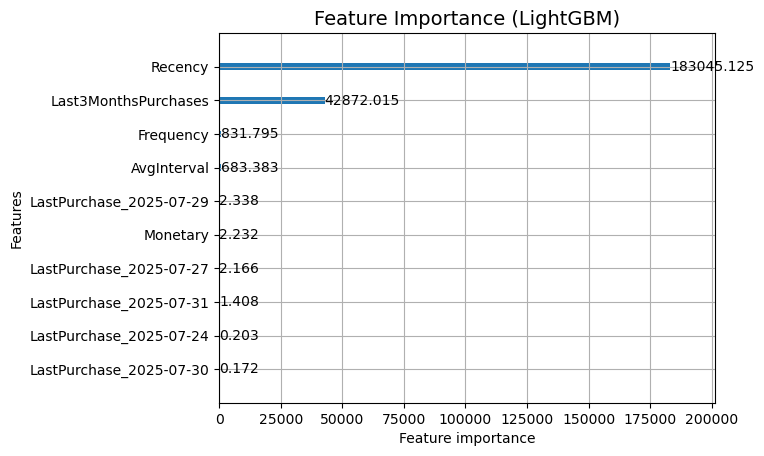


✅ 新規顧客の離反確率予測結果
   Recency  Frequency  Monetary  AvgInterval  Last3MonthsPurchases  \
0      150          2     12000           70                     0   
1       10          8     85000           30                     3   
2       60          4     40000           45                     1   

   Churn_Probability  
0          99.999988  
1           0.000011  
2           0.000017  

📦 出力完了：output/feature_importance_lightgbm.csv


In [8]:
# === モデル構築（LightGBM） ===
model = LGBMClassifier(
    objective="binary",
    random_state=42,
    class_weight="balanced",
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8
)

model.set_params(verbosity=-1)

# === 学習 ===
model.fit(X_train, y_train)

# === 予測 ===
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# === 評価 ===
acc = accuracy_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_prob)
cm = confusion_matrix(y_test, y_pred)

print("✅ モデル評価結果")
print(f"Accuracy: {acc:.3f}")
print(f"ROC-AUC : {roc:.3f}")
print("\n混同行列:")
print(cm)
print("\n詳細:")
print(classification_report(y_test, y_pred))

# === 特徴量重要度 ===
feature_imp = pd.DataFrame({
    "Feature": X.columns,
    "Importance": model.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("\n📊 特徴量重要度（上位10件）")
print(feature_imp.head(10))

# === 可視化 ===
plt.figure(figsize=(8, 6))
plot_importance(model, max_num_features=10, importance_type='gain')
plt.title("Feature Importance (LightGBM)", fontsize=14)
plt.show()

# === 新規顧客離反確率の予測例 ===
new_customers = pd.DataFrame({
    "Recency": [150, 10, 60],
    "Frequency": [2, 8, 4],
    "Monetary": [12000, 85000, 40000],
    "AvgInterval": [70, 30, 45],
    "Last3MonthsPurchases": [0, 3, 1],
    "Age": [45, 38, 52],
    "Gender": ["女性", "男性", "女性"]
})

# --- ダミー変換 ---
new_customers = pd.get_dummies(new_customers, drop_first=True)

# --- 列の整合性を高速・安全に統一 ---
missing_cols = [col for col in X.columns if col not in new_customers.columns]
extra_cols = [col for col in new_customers.columns if col not in X.columns]

# 不足列は一括追加（断片化なし）
if missing_cols:
    add_df = pd.DataFrame(0, index=new_customers.index, columns=missing_cols)
    new_customers = pd.concat([new_customers, add_df], axis=1)

# 余分な列は削除
if extra_cols:
    new_customers = new_customers.drop(columns=extra_cols)

# 列順をモデル学習時と合わせる
new_customers = new_customers[X.columns]

# --- 予測 ---
new_customers["Churn_Probability"] = model.predict_proba(new_customers)[:, 1] * 100

print("\n✅ 新規顧客の離反確率予測結果")
print(new_customers[
    ["Recency", "Frequency", "Monetary", "AvgInterval", "Last3MonthsPurchases", "Churn_Probability"]
])

# === 結果出力 ===
OUTPUT_DIR = ROOT / "output"
OUTPUT_DIR.mkdir(exist_ok=True)
feature_imp.to_csv(OUTPUT_DIR / "feature_importance_lightgbm.csv", index=False)
print("\n📦 出力完了：output/feature_importance_lightgbm.csv")